In [1]:
# imports
import numpy as np
import pandas as pd
import requests
import logging
import pickle

# finance
import yfinance as yf
#import pandas_ta as ta
import talib as ta

# visualisation
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# time
import time
from datetime import date, datetime, timedelta

# maschine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, RocCurveDisplay
from collections import Counter


# 0. Getting Data

In [ ]:
def get_coins():
        # set up logging to display info and error messages
        logging.basicConfig(
            level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
        )

        # list of coins
        coins = [
             #biggest coins
            "BTCUSDT",
            "ETHUSDT",
            "BNBUSDT",
            "SOLUSDT",
            "DOGEUSDT",
            #stablecoin
            "USDCUSDT"
        ]

        def fetch_crypto_ohlc(coin, interval="1h", start_str="1 Aug, 2024"):
            url = "https://api.binance.com/api/v1/klines"

            # convert start date string to datetime object
            start_time = pd.to_datetime(start_str)
            end_time = datetime.now()

            all_data = []

            while start_time < end_time:
                # define request parameters for binance api
                params = {
                    "symbol": coin,
                    "interval": interval,
                    "startTime": int(start_time.timestamp() * 1000),
                    "endTime": int(
                        (start_time + timedelta(days=30)).timestamp() * 1000
                    ),  # fetching 30 days at a time
                }

                response = requests.get(url, params=params)

                # check if request was successful
                if response.status_code != 200:
                    logging.error(f"Error fetching data for {coin}: {response.status_code}")
                    break

                data = response.json()

                # check if data is returned
                if not data:
                    logging.warning(f"No OHLC data found for {coin}.")
                    break

                all_data.extend(data)

                # update start time for next request
                start_time = pd.to_datetime(data[-1][0], unit="ms") + timedelta(
                    milliseconds=1
                )

                logging.info(f"Fetched data for {coin} up to {start_time}")
                time.sleep(0.5)  # pause to avoid api limits

            if not all_data:
                return pd.DataFrame()

            # convert data into df with appropriate column names
            ohlc_df = pd.DataFrame(
                all_data,
                columns=[
                    "timestamp",
                    "open",
                    "high",
                    "low",
                    "close",
                    "volume",
                    "close_time",
                    "quote_asset_volume",
                    "number_of_trades",
                    "taker_buy_base_asset_volume",
                    "taker_buy_quote_asset_volume",
                    "ignore",
                ],
            )

            # columns
            stablecoins = [ "USDCUSDT"]
            ohlc_df["ticker"] = coin
            ohlc_df["ticker_type"] = "stablecoin" if coin in stablecoins else "cryptocurrency"
            ohlc_df['ticker_type'] = ohlc_df['ticker_type'].astype('category')

            # convert price and volume to float
            ohlc_df[["open", "high", "low", "close", "volume"]] = ohlc_df[["open", "high", "low", "close", "volume"]].astype(float)
            ohlc_df["price_change"] = (ohlc_df["close"] - ohlc_df["open"]) / ohlc_df["open"] * 100

            # setting the timezone to Berlin
            ohlc_df["date"] = pd.to_datetime(ohlc_df["timestamp"], unit="ms")
            ohlc_df["date"] = (
                ohlc_df["date"].dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin")
            )
            ohlc_df.set_index("date", inplace=True)

            return ohlc_df[
                [
                    "ticker",
                    "ticker_type",
                    "open",
                    "high",
                    "low",
                    "close",
                    "price_change",
                    "volume"
                ]
            ]

        def generate_datetime_features(df):
            # generate additional datetime features
            df["year"] = df.index.year.astype(int)
            df["month"] = df.index.month.astype(int)
            df["day"] = df.index.weekday.astype(int)
            df["hour"] = df.index.hour.astype(int)

            return df

        # main script
        all_data = pd.DataFrame()

        for coin in coins:
            logging.info(f"Fetching data for {coin}")
            df = fetch_crypto_ohlc(coin)

            if not df.empty:
                df = generate_datetime_features(df)
                all_data = pd.concat([all_data, df])
            else:
                logging.warning(f"No data fetched for {coin}")

        # reorder columns to have datetime features at the beginning
        datetime_features = ["year", "month", "day", "hour", "ticker", "ticker_type"]
        other_columns = [col for col in all_data.columns if col not in datetime_features]
        all_data = all_data[datetime_features + other_columns]

        all_data['ticker'] = all_data['ticker'].astype('category')

        # save df to csv
        all_data.to_csv('crypto.csv', index=True)
        logging.info("Data fetching and processing complete. Data saved to crypto.csv")

        all_data.info()

        all_data.describe()


if __name__ == "__main__":
        get_coins()

2024-11-20 17:40:25,531 - INFO - Fetching data for BTCUSDT
2024-11-20 17:40:26,015 - INFO - Fetched data for BTCUSDT up to 2024-08-21 19:00:00.001000
2024-11-20 17:40:26,936 - INFO - Fetched data for BTCUSDT up to 2024-09-11 15:00:00.001000
2024-11-20 17:40:27,859 - INFO - Fetched data for BTCUSDT up to 2024-10-02 11:00:00.001000
2024-11-20 17:40:29,387 - INFO - Fetched data for BTCUSDT up to 2024-10-23 07:00:00.001000
2024-11-20 17:40:30,319 - INFO - Fetched data for BTCUSDT up to 2024-11-13 03:00:00.001000
2024-11-20 17:40:31,238 - INFO - Fetched data for BTCUSDT up to 2024-11-20 16:00:00.001000
2024-11-20 17:40:32,075 - WARNING - No OHLC data found for BTCUSDT.
2024-11-20 17:40:32,128 - INFO - Fetching data for ETHUSDT
2024-11-20 17:40:32,457 - INFO - Fetched data for ETHUSDT up to 2024-08-21 19:00:00.001000
2024-11-20 17:40:33,388 - INFO - Fetched data for ETHUSDT up to 2024-09-11 15:00:00.001000
2024-11-20 17:40:34,311 - INFO - Fetched data for ETHUSDT up to 2024-10-02 11:00:00.00

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16086 entries, 2024-08-01 02:00:00+02:00 to 2024-11-20 17:00:00+01:00
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          16086 non-null  int64   
 1   month         16086 non-null  int64   
 2   day           16086 non-null  int64   
 3   hour          16086 non-null  int64   
 4   ticker        16086 non-null  category
 5   ticker_type   16086 non-null  object  
 6   open          16086 non-null  float64 
 7   high          16086 non-null  float64 
 8   low           16086 non-null  float64 
 9   close         16086 non-null  float64 
 10  price_change  16086 non-null  float64 
 11  volume        16086 non-null  float64 
dtypes: category(1), float64(6), int64(4), object(1)
memory usage: 1.5+ MB


In [3]:
# get stock data from api and transform it into df and csv
def get_stocks():
    # list of tickers
    snp500_tickers = [
        'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'FB', 'TSLA', 'BRK.B', 'NVDA',
        'JPM', 'JNJ', 'V', 'PG', 'UNH', 'HD', 'MA', 'DIS', 'PYPL', 'VZ',
        'INTC', 'NFLX', 'CMCSA', 'PEP', 'T', 'CSCO', 'PFE', 'ADBE',
        'NKE', 'MRK', 'XOM', 'AVGO', 'ABT', 'CRM', 'TMO', 'AMD', 'LLY',
        'NKE', 'IBM', 'COST', 'LMT', 'WMT', 'MDT', 'CVX', 'HON',
        'TXN', 'NOW', 'QCOM', 'BMY', 'SBUX', 'DHR', 'AMGN', 'CAT'
    ]

    dax_tickers = [
        'ADS', 'ALV', 'BAK', 'BAS', 'BEI', 'BMW', 'BVB', 'DBK',
        'DPW', 'DTE', 'EON', 'FRE', 'HEI', 'LHA', 'LIN', 'MRK',
        'RWE', 'SAP', 'SIE', 'VOW3'
    ]

    important_stocks = [
        'AAL', 'ABEV', 'AGNC', 'AVGO', 'BAC', 'BA', 'BBD', 'BHP',
        'BKKT', 'BLK', 'BP', 'CAN', 'CCL', 'CMG', 'CME', 'COIN',
        'CRM', 'CVX', 'DOCN', 'DJT', 'EBON', 'ERIC', 'F', 'FIDELITY',
        'GLD', 'GLXY', 'GOLD', 'GOOG', 'GRAB', 'GS', 'HUT', 'ICE',
        'IONQ', 'JBLU', 'JOBY', 'KDP', 'KGC', 'KSV', 'LCID', 'MARA',
        'MS', 'MSFT', 'MSTR', 'NDAQ', 'NEM', 'NIO', 'NYCB', 'NU',
        'OKLO', 'PLTR', 'PAYX', 'PFE', 'RIOT', 'RIVN', 'SI', 'SNAP',
        'SOUN', 'SOFI', 'SMCI', 'SPGI', 'SQ', 'T', 'TWLO', 'VALE',
        'VFC', 'WULF', 'XOM'
    ]

    comb_stocks = snp500_tickers + dax_tickers + important_stocks
    # sorting and removing duplicates
    stocks = sorted(set(comb_stocks))

    # timeframe
    end_date = datetime.now()
    start_date = end_date - timedelta(days=60)
    interval = '1h'

    # list for saving data
    all_data = []

    # getting data
    for stock in stocks:
        print(f"Fetching data for {stock}...")
        try:
            ticker = yf.Ticker(stock)
            df = ticker.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), interval=interval)

            if df.empty:
                print(f"No data found for {stock}. This might indicate it's delisted or has no data in this period.")
            else:
                df['ticker'] = stock
                df = df.drop(columns=['Dividends', 'Stock Splits', 'Capital Gains'], errors='ignore')

                # timezone Europe/Berlin
                df.index = pd.to_datetime(df.index, utc=True).tz_convert("Europe/Berlin")
                df.index.name = 'date'

                df['year'] = df.index.year.astype(int)
                df['month'] = df.index.month.astype(int)
                df['day'] = df.index.day.astype(int)
                df['hour'] = df.index.hour.astype(int)
                all_data.append(df)
                print(f"Data for {stock} successfully fetched.")

        except Exception as e:
            print(f"An error occurred for {stock}: {e}")

    # combining into one df
    if all_data:
        combined_data = pd.concat(all_data)
        # all lower
        combined_data.columns = combined_data.columns.str.lower()
        # adding price change in percent, tickertype
        combined_data['price_change'] = (combined_data['close'] - combined_data['open']) / combined_data['open'] * 100
        combined_data['ticker_type'] = 'stock'
        combined_data['ticker_type'] = combined_data['ticker_type'].astype('category')
        combined_data['ticker'] = combined_data['ticker'].astype('category')

        # sorting
        column_order = ['year', 'month', 'day', 'hour', 'ticker', 'ticker_type', 'open', 'high', 'low', 'close', 'price_change', 'volume']
        combined_data = combined_data[column_order]

        # saving
        combined_data.to_csv('stocks_60d.csv', index=True)
        print("Combined data saved.")

        combined_data.head(12)


    else:
        print("No data to save.")

    print("Data extraction complete! Please check the logs for errors.")

    # eda

    combined_data.nunique()

    combined_data.info()

    combined_data.describe()

    combined_data.isna().sum()

if __name__ == "__main__":
    get_stocks()

Fetching data for AAL...
Data for AAL successfully fetched.
Fetching data for AAPL...
Data for AAPL successfully fetched.
Fetching data for ABEV...
Data for ABEV successfully fetched.
Fetching data for ABT...
Data for ABT successfully fetched.
Fetching data for ADBE...
Data for ADBE successfully fetched.
Fetching data for ADS...


$ADS: possibly delisted; no timezone found


No data found for ADS. This might indicate it's delisted or has no data in this period.
Fetching data for AGNC...
Data for AGNC successfully fetched.
Fetching data for ALV...
Data for ALV successfully fetched.
Fetching data for AMD...
Data for AMD successfully fetched.
Fetching data for AMGN...
Data for AMGN successfully fetched.
Fetching data for AMZN...
Data for AMZN successfully fetched.
Fetching data for AVGO...
Data for AVGO successfully fetched.
Fetching data for BA...
Data for BA successfully fetched.
Fetching data for BAC...
Data for BAC successfully fetched.
Fetching data for BAK...
Data for BAK successfully fetched.
Fetching data for BAS...


$BAS: possibly delisted; no timezone found
$BEI: possibly delisted; no price data found  (1h 2024-10-07 -> 2024-12-06)


No data found for BAS. This might indicate it's delisted or has no data in this period.
Fetching data for BBD...
Data for BBD successfully fetched.
Fetching data for BEI...
No data found for BEI. This might indicate it's delisted or has no data in this period.
Fetching data for BHP...
Data for BHP successfully fetched.
Fetching data for BKKT...
Data for BKKT successfully fetched.
Fetching data for BLK...


$BMW: possibly delisted; no price data found  (1h 2024-10-07 -> 2024-12-06)


Data for BLK successfully fetched.
Fetching data for BMW...
No data found for BMW. This might indicate it's delisted or has no data in this period.
Fetching data for BMY...
Data for BMY successfully fetched.
Fetching data for BP...
Data for BP successfully fetched.
Fetching data for BRK.B...


$BRK.B: possibly delisted; no timezone found
$BVB: possibly delisted; no price data found  (1h 2024-10-07 -> 2024-12-06)


No data found for BRK.B. This might indicate it's delisted or has no data in this period.
Fetching data for BVB...
No data found for BVB. This might indicate it's delisted or has no data in this period.
Fetching data for CAN...
Data for CAN successfully fetched.
Fetching data for CAT...
Data for CAT successfully fetched.
Fetching data for CCL...
Data for CCL successfully fetched.
Fetching data for CMCSA...
Data for CMCSA successfully fetched.
Fetching data for CME...
Data for CME successfully fetched.
Fetching data for CMG...
Data for CMG successfully fetched.
Fetching data for COIN...
Data for COIN successfully fetched.
Fetching data for COST...
Data for COST successfully fetched.
Fetching data for CRM...
Data for CRM successfully fetched.
Fetching data for CSCO...
Data for CSCO successfully fetched.
Fetching data for CVX...
Data for CVX successfully fetched.
Fetching data for DBK...


$DBK: possibly delisted; no price data found  (1h 2024-10-07 -> 2024-12-06)


No data found for DBK. This might indicate it's delisted or has no data in this period.
Fetching data for DHR...
Data for DHR successfully fetched.
Fetching data for DIS...
Data for DIS successfully fetched.
Fetching data for DJT...
Data for DJT successfully fetched.
Fetching data for DOCN...
Data for DOCN successfully fetched.
Fetching data for DPW...


$DPW: possibly delisted; no timezone found


No data found for DPW. This might indicate it's delisted or has no data in this period.
Fetching data for DTE...
Data for DTE successfully fetched.
Fetching data for EBON...


$EON: possibly delisted; no price data found  (1h 2024-10-07 -> 2024-12-06)


Data for EBON successfully fetched.
Fetching data for EON...
No data found for EON. This might indicate it's delisted or has no data in this period.
Fetching data for ERIC...
Data for ERIC successfully fetched.
Fetching data for F...
Data for F successfully fetched.
Fetching data for FB...


$FB: possibly delisted; no timezone found


No data found for FB. This might indicate it's delisted or has no data in this period.
Fetching data for FIDELITY...


$FIDELITY: possibly delisted; no timezone found
$FRE: possibly delisted; no price data found  (1h 2024-10-07 -> 2024-12-06)


No data found for FIDELITY. This might indicate it's delisted or has no data in this period.
Fetching data for FRE...
No data found for FRE. This might indicate it's delisted or has no data in this period.
Fetching data for GLD...
Data for GLD successfully fetched.
Fetching data for GLXY...


$GLXY: possibly delisted; no timezone found


No data found for GLXY. This might indicate it's delisted or has no data in this period.
Fetching data for GOLD...
Data for GOLD successfully fetched.
Fetching data for GOOG...
Data for GOOG successfully fetched.
Fetching data for GOOGL...
Data for GOOGL successfully fetched.
Fetching data for GRAB...
Data for GRAB successfully fetched.
Fetching data for GS...
Data for GS successfully fetched.
Fetching data for HD...
Data for HD successfully fetched.
Fetching data for HEI...
Data for HEI successfully fetched.
Fetching data for HON...
Data for HON successfully fetched.
Fetching data for HUT...
Data for HUT successfully fetched.
Fetching data for IBM...
Data for IBM successfully fetched.
Fetching data for ICE...
Data for ICE successfully fetched.
Fetching data for INTC...
Data for INTC successfully fetched.
Fetching data for IONQ...
Data for IONQ successfully fetched.
Fetching data for JBLU...
Data for JBLU successfully fetched.
Fetching data for JNJ...
Data for JNJ successfully fetched.

$KSV: possibly delisted; no price data found  (1h 2024-10-07 -> 2024-12-06)


Data for KDP successfully fetched.
Fetching data for KGC...
Data for KGC successfully fetched.
Fetching data for KSV...
No data found for KSV. This might indicate it's delisted or has no data in this period.
Fetching data for LCID...


$LHA: possibly delisted; no price data found  (1h 2024-10-07 -> 2024-12-06)


Data for LCID successfully fetched.
Fetching data for LHA...
No data found for LHA. This might indicate it's delisted or has no data in this period.
Fetching data for LIN...
Data for LIN successfully fetched.
Fetching data for LLY...
Data for LLY successfully fetched.
Fetching data for LMT...
Data for LMT successfully fetched.
Fetching data for MA...
Data for MA successfully fetched.
Fetching data for MARA...
Data for MARA successfully fetched.
Fetching data for MDT...
Data for MDT successfully fetched.
Fetching data for MRK...
Data for MRK successfully fetched.
Fetching data for MS...
Data for MS successfully fetched.
Fetching data for MSFT...
Data for MSFT successfully fetched.
Fetching data for MSTR...
Data for MSTR successfully fetched.
Fetching data for NDAQ...
Data for NDAQ successfully fetched.
Fetching data for NEM...
Data for NEM successfully fetched.
Fetching data for NFLX...
Data for NFLX successfully fetched.
Fetching data for NIO...
Data for NIO successfully fetched.
Fetch

$RWE: possibly delisted; no price data found  (1h 2024-10-07 -> 2024-12-06)


Data for RIOT successfully fetched.
Fetching data for RIVN...
Data for RIVN successfully fetched.
Fetching data for RWE...
No data found for RWE. This might indicate it's delisted or has no data in this period.
Fetching data for SAP...
Data for SAP successfully fetched.
Fetching data for SBUX...
Data for SBUX successfully fetched.
Fetching data for SI...


$SI: possibly delisted; no timezone found
$SIE: possibly delisted; no price data found  (1h 2024-10-07 -> 2024-12-06)


No data found for SI. This might indicate it's delisted or has no data in this period.
Fetching data for SIE...
No data found for SIE. This might indicate it's delisted or has no data in this period.
Fetching data for SMCI...
Data for SMCI successfully fetched.
Fetching data for SNAP...
Data for SNAP successfully fetched.
Fetching data for SOFI...
Data for SOFI successfully fetched.
Fetching data for SOUN...
Data for SOUN successfully fetched.
Fetching data for SPGI...
Data for SPGI successfully fetched.
Fetching data for SQ...
Data for SQ successfully fetched.
Fetching data for T...
Data for T successfully fetched.
Fetching data for TMO...
Data for TMO successfully fetched.
Fetching data for TSLA...
Data for TSLA successfully fetched.
Fetching data for TWLO...
Data for TWLO successfully fetched.
Fetching data for TXN...
Data for TXN successfully fetched.
Fetching data for UNH...
Data for UNH successfully fetched.
Fetching data for V...
Data for V successfully fetched.
Fetching data fo

$VOW3: possibly delisted; no timezone found


No data found for VOW3. This might indicate it's delisted or has no data in this period.
Fetching data for VZ...
Data for VZ successfully fetched.
Fetching data for WMT...
Data for WMT successfully fetched.
Fetching data for WULF...
Data for WULF successfully fetched.
Fetching data for XOM...
Data for XOM successfully fetched.
Combined data saved.
Data extraction complete! Please check the logs for errors.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32436 entries, 2024-10-07 15:30:00+02:00 to 2024-12-05 21:30:00+01:00
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          32436 non-null  int64   
 1   month         32436 non-null  int64   
 2   day           32436 non-null  int64   
 3   hour          32436 non-null  int64   
 4   ticker        32436 non-null  category
 5   ticker_type   32436 non-null  category
 6   open          32436 non-null  float64 
 7   high          32436 non-null  flo

In [3]:
#combining them into one df
stocks_df = pd.read_csv('stocks.csv')
crypto_df = pd.read_csv('stable_coin.csv')

# concat
df = pd.concat([stocks_df, crypto_df], ignore_index=True)

# transform object to category
df['ticker'] = df['ticker'].astype('category')
df['ticker_type'] = df['ticker_type'].astype('category')

In [5]:
print(df.shape)


(47481, 13)


# 1. Feature Engeneering

In [8]:
# creating new columns
# moving averages
df['7d_ma'] = df['close'].rolling(window=7).mean()
df['30d_ma'] = df['close'].rolling(window=30).mean()

# volatility (standard deviation of 'close' over last 7 days)
df['7d_volatility'] = df['close'].rolling(window=7).std()

# intraday range
df['intraday_range'] = (df['high'] - df['low']) / df['low']

# lag features
df['close_lag_1'] = df['close'].shift(1)

# talib
def add_ta_indicators(df):
    # ensure columns have correct data types
    df["open"] = df["open"].astype("float64")
    df["high"] = df["high"].astype("float64")
    df["low"] = df["low"].astype("float64")
    df["close"] = df["close"].astype("float64")
    df["volume"] = df["volume"].astype("float64")

    # calculate various technical indicators using TA-Lib
    df['adx'] = ta.ADX(df['high'], df['low'], df['close'])
    df['aroon'] = ta.AROON(df['high'], df['low'])[0]  # AROON Up
    df['bop'] = ta.BOP(df['open'], df['high'], df['low'], df['close'])
    df['cci'] = ta.CCI(df['high'], df['low'], df['close'])
    df['cmo'] = ta.CMO(df['close'])
    df['macd'], df['macd_signal'], df['macd_hist'] = ta.MACD(df['close'])
    df['mom'] = ta.MOM(df['close'])
    df['ppo'] = ta.PPO(df['close'])
    df['roc'] = ta.ROC(df['close'])
    df['rsi'] = ta.RSI(df['close'])
    df['willr'] = ta.WILLR(df['high'], df['low'], df['close'])
    df['atr'] = ta.ATR(df['high'], df['low'], df['close'])
    df['trix'] = ta.TRIX(df['close'])
    df['kama'] = ta.KAMA(df['close'])

    return df

df = add_ta_indicators(df)


# custom calculations
def add_custom_calculations(df, group_by_col="ticker"):
        # growth calculations for different time periods
        for hours in [1, 4, 24, 48, 72, 168, 336, 720]:
            df[f"growth_{hours}h"] = (
                df.groupby(group_by_col, observed=True)["close"].shift(hours) / df["close"]
            )
            future_shifted = df.groupby(group_by_col, observed=True)["close"].shift(-hours)
            df[f"growth_future_{hours}h"] = future_shifted / df["close"]
            df[f"is_positive_growth_{hours}h_future"] = np.where(
                df[f"growth_future_{hours}h"] > 1, 1, 0
            )

        # fibonacci levels
        df["fibonacci_0"] = df["close"]
        df["fibonacci_23_6"] = df["high"] - (df["high"] - df["low"]) * 0.236
        df["fibonacci_38_2"] = df["high"] - (df["high"] - df["low"]) * 0.382
        df["fibonacci_50"] = df["high"] - (df["high"] - df["low"]) * 0.5
        df["fibonacci_61_8"] = df["high"] - (df["high"] - df["low"]) * 0.618
        df["fibonacci_100"] = df["low"]

        return df

df = add_custom_calculations(df)

# 2. EDA

In [12]:
# checking for nan all rows colums
nan_counts = df.isna().sum()
print(f"NAN for ticker: {nan_counts}")

# 0 values per row
zero_counts = (df == 0).sum()
zero_columns = zero_counts[zero_counts > 0].sort_values(ascending=False).head(10)
print("Top columns with 0 values:")
print(f"0 values {zero_columns}")

# deleting rows where day is 0
df.drop(df[df['day'] == 0].index, inplace=True)

# printing datatypes
print(f"Data types: {df.dtypes}")

# getting overview of unique tickers
unique_tickers = df['ticker'].nunique()
print(f"Number of individuel ticker: {unique_tickers}")

for col in df.columns:
    print(col)
    print(df[col].nunique())
    print()

# overview stats
usdcusdt_data = df[df['ticker'] == 'USDCUSDT']

stats_summary = usdcusdt_data.describe()
print(stats_summary)

# number of data for 'close'
n = len(usdcusdt_data)
print(f"Number of data for USDCUSDT: {n}")

# Find max and min price change
max_price_change = usdcusdt_data['price_change'].max()
print("Max price change for USDC:", max_price_change)


NAN for ticker: date              0
year              0
month             0
day               0
hour              0
                 ..
fibonacci_23_6    0
fibonacci_38_2    0
fibonacci_50      0
fibonacci_61_8    0
fibonacci_100     0
Length: 64, dtype: int64
Top columns with 0 values:
0 values is_positive_growth_720h_future    39738
is_positive_growth_336h_future    39354
is_positive_growth_168h_future    31175
is_positive_growth_72h_future     25501
is_positive_growth_48h_future     24840
is_positive_growth_1h_future      24486
is_positive_growth_24h_future     24443
is_positive_growth_4h_future      24048
aroon                              7537
day                                2160
dtype: int64
Data types: date               object
year                int64
month               int64
day                 int64
hour                int64
                   ...   
fibonacci_23_6    float64
fibonacci_38_2    float64
fibonacci_50      float64
fibonacci_61_8    float64
fibonacci_100     

Correlation matrix for stablecoins:
                price_change     close      open    volume  intraday_range  \
price_change        1.000000  0.101264 -0.123388  0.087048        0.095403   
close               0.101264  1.000000  0.974763 -0.152309       -0.113656   
open               -0.123388  0.974763  1.000000 -0.171450       -0.134775   
volume              0.087048 -0.152309 -0.171450  1.000000        0.755448   
intraday_range      0.095403 -0.113656 -0.134775  0.755448        1.000000   
7d_volatility       0.042001  0.049645  0.040090  0.002311        0.012906   
growth_1h          -0.819821 -0.112951  0.071281 -0.088167       -0.072124   

                7d_volatility  growth_1h  
price_change         0.042001  -0.819821  
close                0.049645  -0.112951  
open                 0.040090   0.071281  
volume               0.002311  -0.088167  
intraday_range       0.012906  -0.072124  
7d_volatility        1.000000  -0.016687  
growth_1h           -0.016687   1.0000

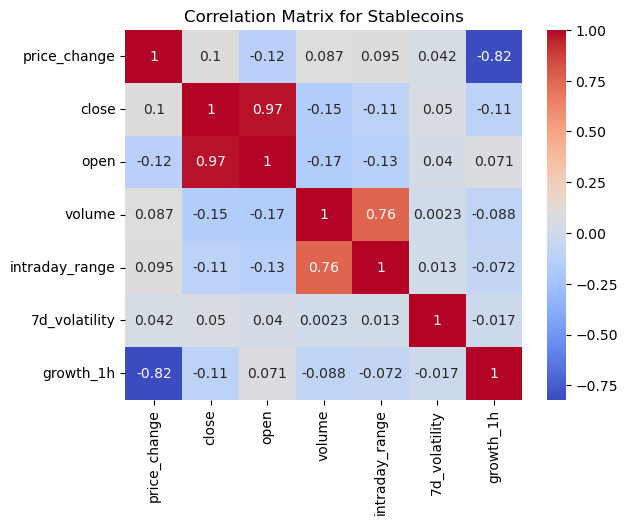

In [13]:
stablecoin_data = df[df['ticker_type'] == 'stablecoin']
cor_columns = ['price_change', 'close', 'open', 'volume', 'intraday_range', '7d_volatility', 'growth_1h']
correlation_matrix_stablecoin = stablecoin_data[cor_columns].corr()
print("Correlation matrix for stablecoins:")
print(correlation_matrix_stablecoin)

# Optional heatmap
sns.heatmap(correlation_matrix_stablecoin, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for Stablecoins")
plt.savefig("images/correlation_matrix_stablecoin.png", dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Correlation insights:
#  Strong positive correlation between 'open' and 'close' (0.97), indicating that the opening and closing prices tend to move together.
# 'price_change' is negatively correlated with 'growth_1h' (-0.82), suggesting a strong inverse relationship between price change and 1-hour growth.
# This strong inverse relationship suggests that as the overall price change increases (positive or negative), the short-term (1-hour) growth rate decreases. 
# This could imply that larger price changes in stablecoins tend to smooth out over time, stabilizing their price movements quickly.
# 'volume' and 'intraday_range' show a moderate positive correlation (0.76), implying that higher trading volume corresponds to larger price ranges within a day.
# '7d_volatility' shows weak correlations with most variables, suggesting it may not be heavily influenced by these features.
# Generally, features show moderate to weak correlations with 'price_change', except for 'growth_1h', which has a strong negative correlation.

# Large trading volumes can cause higher intraday price ranges.
# Price change and short-term growth behave inversely, emphasizing stablecoins' tendency to re-align their prices.
# Features like growth_1h and intraday_range appear particularly relevant for modeling price_change

## 2.1 Visualisation

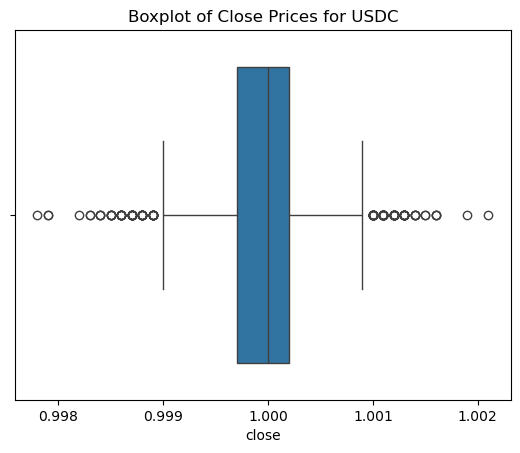

In [18]:
# boxplot
sns.boxplot(x=usdcusdt_data['close'])
plt.title('Boxplot of Close Prices for USDC')
plt.savefig('images/boxplot_usdc.png')
plt.show()

In [20]:
# Key Insights:
# **Stability of USDC**: The majority of the 'Close Prices' are very close to 1, indicating that USDC is functioning well as a stablecoin
# **Outlier Analysis**: There are outliers below 0.999 and above 1.001, which could be caused by short-term market movements or external events affecting its stability
# **Narrow Range**: The Interquartile Range (IQR) is extremely small, indicating that USDC is traded consistently with minimal fluctuations
# **Frequent Deviations**: The symmetrical outliers on both sides of 1 could indicate market mechanisms like arbitrage or liquidity movements

In [22]:
# looking closer at outliers
# Define thresholds for outliers
lower_threshold = 0.999
upper_threshold = 1.001

# Find outliers based on the close price
outliers = usdcusdt_data[(usdcusdt_data['close'] < lower_threshold) | (usdcusdt_data['close'] > upper_threshold)]

# Display outlier timestamps and corresponding close prices
outliers[['year','month', 'day', 'hour', 'close']]


,year,month,day,hour,close
44948,2024,8,3,22,1.0011
44974,2024,8,5,0,1.0011
44975,2024,8,5,1,1.0011
44976,2024,8,5,2,1.0012
44977,2024,8,5,3,1.0012
...,...,...,...,...,...
47445,2024,11,2,22,0.9989
47446,2024,11,2,23,0.9988
47447,2024,11,3,0,0.9986
47448,2024,11,3,1,0.9989


In [24]:
# outliers occur mostly in clusters 
# outliers tend to happen in consecutive hours, suggesting possible market distortions or technical issues during specific periods 
# no clear pattern in terms of specific times, but frequent deviations 
# in early November could indicate heightened volatility or market stress, days around election  
# patterns hinting to external market events / liquidity shifts

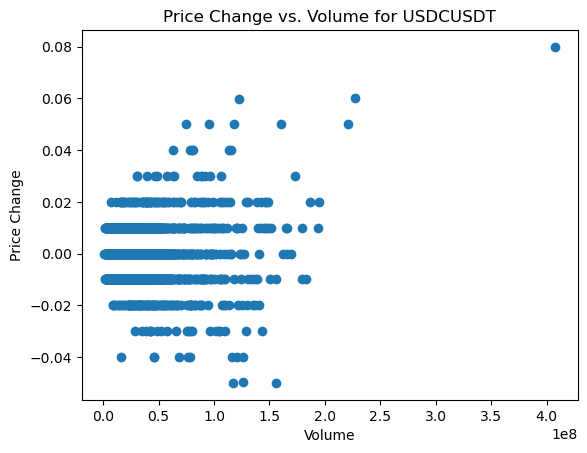

In [26]:
# does price change correlate with volume
plt.scatter(usdcusdt_data['volume'], usdcusdt_data['price_change'])
plt.title('Price Change vs. Volume for USDCUSDT')
plt.xlabel('Volume')
plt.ylabel('Price Change')
plt.savefig('images/price_change_correlation_with_volume.png')
plt.show()

In [28]:
# The scatter plot shows the relationship between price change and trading volume for USDC/USDT.
# Most price changes are centered around 0, indicating stable behavior, even with varying volumes.
# There is a notable outlier with very high volume (~4e8) and a significant price change (~0.08).
# No clear linear correlation between volume and price change is observed, suggesting external factors 
# might influence price deviations more than volume alone.


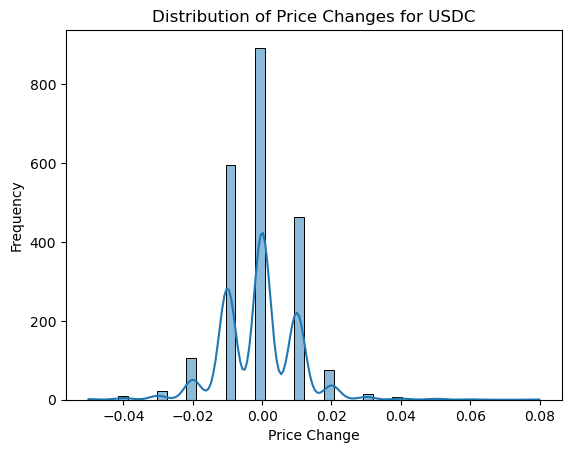

In [61]:
# histogram price_change for USDC
# calculating optimal bin
n = len(usdcusdt_data)
bins = int(np.sqrt(n))
sns.histplot(usdcusdt_data['price_change'], bins=bins, kde=True)
plt.xlabel('Price Change')
plt.ylabel('Frequency')
plt.title('Distribution of Price Changes for USDC')
plt.savefig('images/distribution_price_change.png')
plt.show()

In [ ]:
# The histogram visualizes the distribution of price changes for USDC, a stablecoin.
# Key observations:
# - Most price changes are concentrated around 0, indicating that USDC's price remains stable, as expected for a stablecoin.
# - Distribution analysis:
#   1. Peak at 0: The high frequency of 0 price changes confirms minimal fluctuations for USDC in most cases.
#   2. Symmetric distribution: Price changes are evenly spread on both sides, showing that deviations (positive and negative) are rare and balanced.
#   3. Outliers: Smaller bars farther from 0 represent rare, larger price changes, which are atypical.
# - Implications:
#   - This validates USDC's stability, making it suitable as a reserve asset or a medium of exchange.
#   - The rare outliers might be caused by extreme market events or technical issues.


# 3. Maschine Learning

## 3.1 Preparation

In [21]:
# dropping date
if 'date' in df.columns:
    df.drop(columns=['date'], inplace=True)


df = df.fillna(df.select_dtypes(include=['number']).mean())

# new csv
df.to_csv('one_df.csv', index=False)

# splitting
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# y  USDCUSDT
y_train = df_train['is_positive_growth_1h_future'].values
y_val = df_val['is_positive_growth_1h_future'].values
y_test = df_test['is_positive_growth_1h_future'].values

df_full_train = df_full_train.reset_index(drop=True)

df_full_train.close.value_counts(normalize=True)

df_full_train.close.mean()

# del what we want to predict
del df_train['is_positive_growth_1h_future']
del df_val['is_positive_growth_1h_future']
del df_test['is_positive_growth_1h_future']

In [22]:
numerical = ['open', 'high', 'low', 'volume', 'price_change', 'close',
             'growth_4h', 'growth_24h', 'growth_48h', 'growth_72h',
             'growth_168h', 'growth_336h', 'growth_720h']

categorical = ['year', 'month', 'day', 'hour', 'ticker', 'ticker_type']

technical = ['adx', 'aroon', 'bop', 'cci', 'cmo', 'macd', 'macd_signal', 'macd_hist',
            'mom', 'ppo', 'roc', 'rsi', 'willr', 'atr', 'trix', 'kama',
            '7d_ma', '30d_ma', '7d_volatility', 'intraday_range', 'fibonacci_0',
            'fibonacci_23_6', 'fibonacci_38_2', 'fibonacci_50', 'fibonacci_61_8',
            'fibonacci_100']

growth = ['growth_future_4h','is_positive_growth_24h_future', 'is_positive_growth_48h_future',
            'is_positive_growth_72h_future', 'is_positive_growth_168h_future',
            'is_positive_growth_336h_future', 'is_positive_growth_720h_future']

In [25]:
# defining features
X_train = df_train
X_val = df_val
X_test = df_test

# one hot encoding
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical + numerical + technical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical + technical].to_dict(orient='records')
X_val = dv.transform(val_dict)

# transforming test data
test_dict = df_test[categorical + numerical + technical].to_dict(orient='records')
X_test = dv.transform(test_dict)

## 3.2 Logistic Regression

In [49]:
# model
model_lr = LogisticRegression(class_weight='balanced', solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)

# pred for validation set
y_pred_val_lr = model_lr.predict(X_val)

# evaluation
print(f"Logistic Regression Accuracy on Validation-Set: {accuracy_score(y_val, y_pred_val_lr)}")
print(f"Logistic Regression Confusion Matrix on Validation-Set:\n{confusion_matrix(y_val, y_pred_val_lr)}")
print(f"Logistic Regression Classification Report on Validation-Set:\n{classification_report(y_val, y_pred_val_lr)}")
print(f"Logistic Regression F1-Score on Validation-Set: {f1_score(y_val, y_pred_val_lr)}")
print(f"Logistic Regression ROC-AUC on Validation-Set: {roc_auc_score(y_val, model_lr.predict_proba(X_val)[:, 1])}")

# use model on test set and check results
y_pred_test = model_lr.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

print(f"Accuracy on Test-Set: {accuracy_test}")
print(f"Confusion Matrix on Test-Set: \n{conf_matrix_test}")
print(f"Classification Report on Test-Set: \n{class_report_test}")


# original accuracy with all features
original_accuracy = accuracy_score(y_val, model_lr.predict(X_val))
print(f"Original Accuracy: {original_accuracy}")

# store results
feature_accuracies = {}
# store feature names
feature_names = dv.get_feature_names_out()

# loop through each feature
for feature_idx in range(X_train.shape[1]):
    # remove the current feature
    X_train_reduced = X_train[:, [i for i in range(X_train.shape[1]) if i != feature_idx]]
    X_val_reduced = X_val[:, [i for i in range(X_val.shape[1]) if i != feature_idx]]

    # train new model
    model_lr_reduced = LogisticRegression(class_weight='balanced', solver='liblinear',
                                          C=1.0, max_iter=1000, random_state=42)
    model_lr_reduced.fit(X_train_reduced, y_train)

    # evaluate new accuracy
    reduced_accuracy = accuracy_score(y_val, model_lr_reduced.predict(X_val_reduced))
    accuracy_difference = original_accuracy - reduced_accuracy

    # map index to feature name and store accuracy difference
    feature_accuracies[feature_names[feature_idx]] = accuracy_difference

# print results with feature names
for feature_name, acc_diff in feature_accuracies.items():
    print(f"Feature: {feature_name}, Accuracy Difference: {acc_diff:.4f}")

# extracting just the important features
important_features = [feature for feature, diff in feature_accuracies.items() if diff != 0.0]
print("Important Features:", important_features)

# new set with reduced data
X_train_reduced = X_train[:, [feature_names.tolist().index(feature) for feature in important_features]]
X_val_reduced = X_val[:, [feature_names.tolist().index(feature) for feature in important_features]]
X_test_reduced = X_test[:, [feature_names.tolist().index(feature) for feature in important_features]]

# new model
model_lr_reduced = LogisticRegression(class_weight='balanced', solver='liblinear',
                                      C=1.0, max_iter=1000, random_state=42)
model_lr_reduced.fit(X_train_reduced, y_train)

y_pred_val_reduced = model_lr_reduced.predict(X_val_reduced)

accuracy_val_reduced = accuracy_score(y_val, y_pred_val_reduced)
print(f"Accuracy on reduced Validation-Set: {accuracy_val_reduced}")
print(f"Confusion Matrix on reduced Validation-Set:\n{confusion_matrix(y_val, y_pred_val_reduced)}")
print(f"Classification Report on reduced Validation-Set:\n{classification_report(y_val, y_pred_val_reduced)}")

# check test data
y_pred_test_reduced = model_lr_reduced.predict(X_test_reduced)
accuracy_test_reduced = accuracy_score(y_test, y_pred_test_reduced)
print(f"Accuracy on Test-Set: {accuracy_test_reduced}")


Logistic Regression Accuracy on Validation-Set: 0.519748455428067
Logistic Regression Confusion Matrix on Validation-Set:
[[4450  223]
 [4130  261]]
Logistic Regression Classification Report on Validation-Set:
              precision    recall  f1-score   support

           0       0.52      0.95      0.67      4673
           1       0.54      0.06      0.11      4391

    accuracy                           0.52      9064
   macro avg       0.53      0.51      0.39      9064
weighted avg       0.53      0.52      0.40      9064

Logistic Regression F1-Score on Validation-Set: 0.10707692307692308
Logistic Regression ROC-AUC on Validation-Set: 0.5194894835520177
Accuracy on Test-Set: 0.5118587975730833
Confusion Matrix on Test-Set: 
[[4409  230]
 [4195  231]]
Classification Report on Test-Set: 
              precision    recall  f1-score   support

           0       0.51      0.95      0.67      4639
           1       0.50      0.05      0.09      4426

    accuracy                  

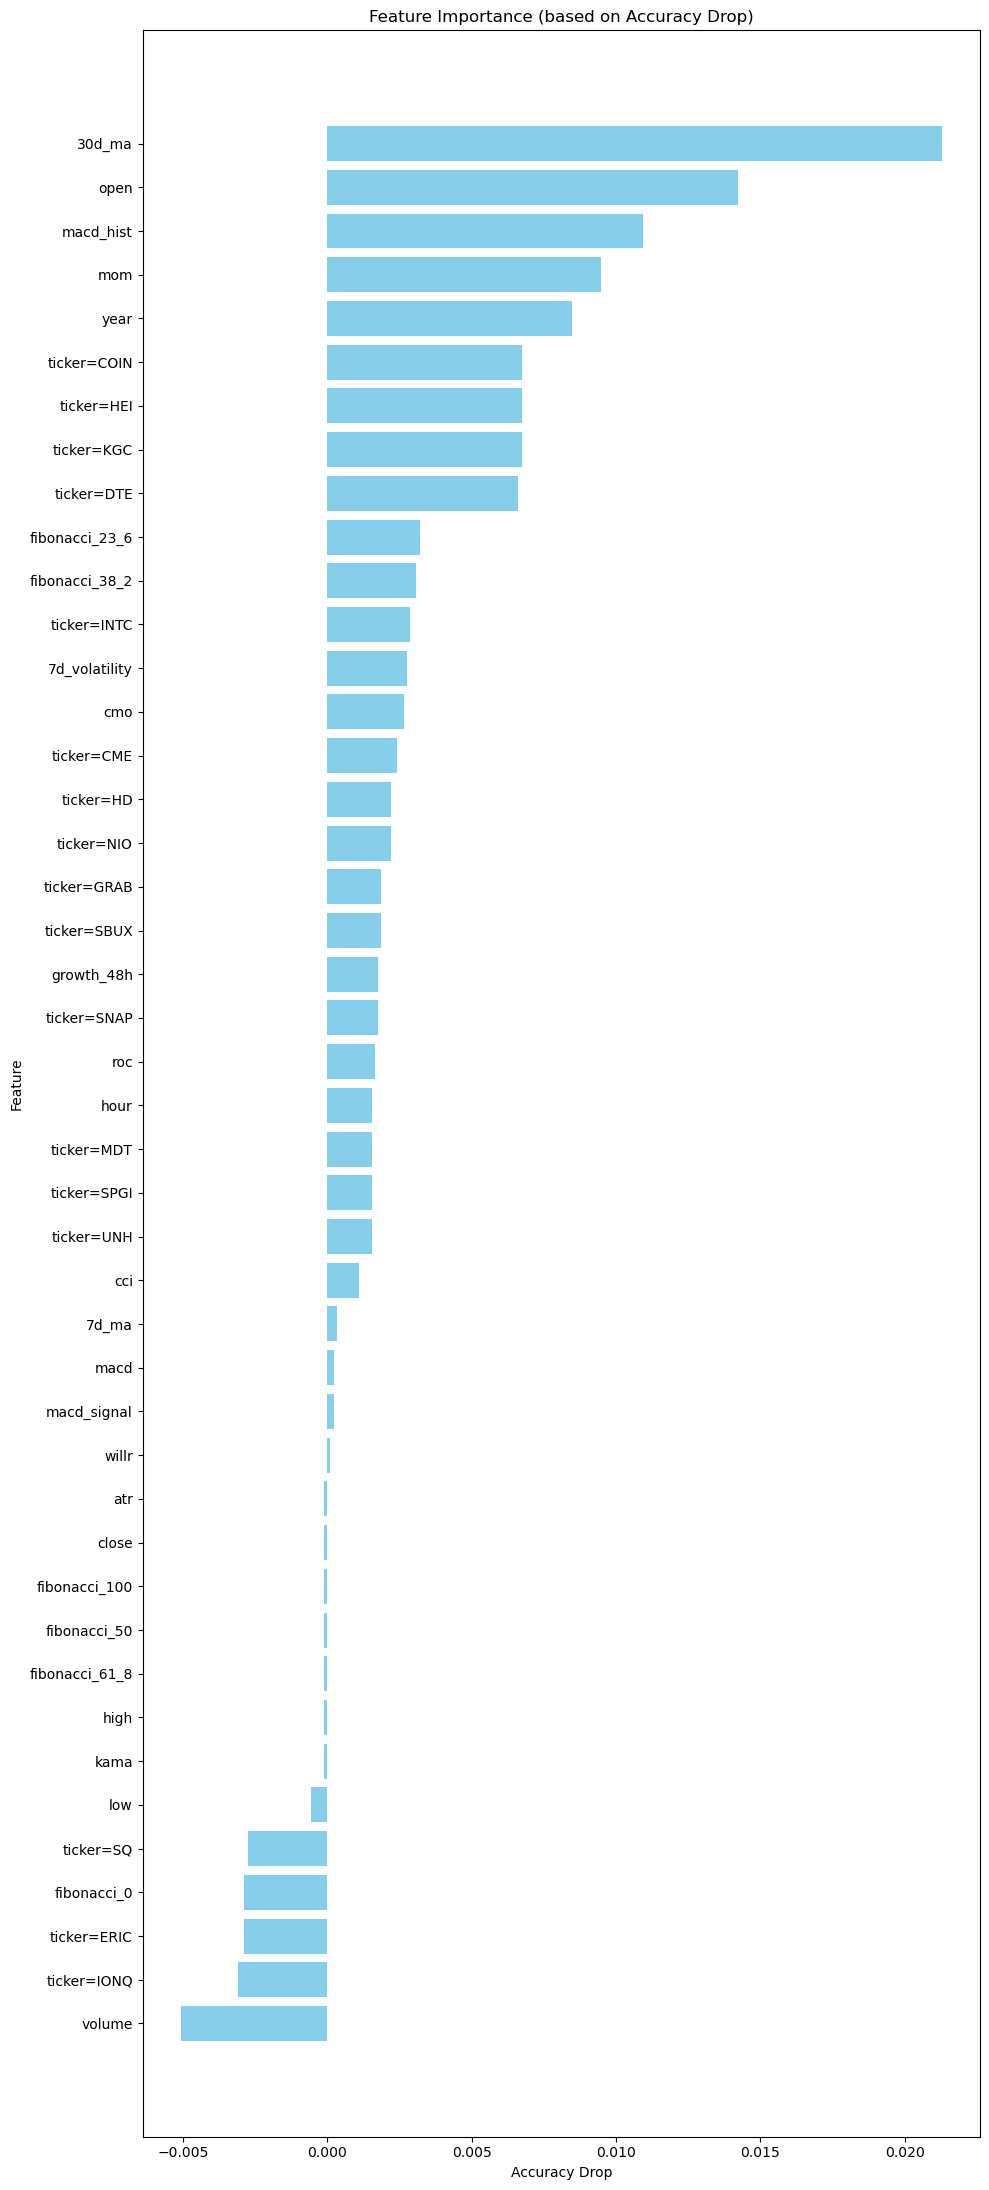

In [ ]:
# filter out features with 0 impact
filtered_features = {k: v for k, v in feature_accuracies.items() if v != 0.0}

# sort remaining features
sorted_features = sorted(filtered_features.items(), key=lambda x: x[1], reverse=True)
features, importance = zip(*sorted_features)

# plot updated chart
plt.figure(figsize=(10, len(features) * 0.5))  
plt.barh(features, importance, color='skyblue')
plt.xlabel('Accuracy Drop')
plt.ylabel('Feature')
plt.title('Feature Importance (based on Accuracy Drop)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('images/feature_importance_lr.png')
plt.show()


In [ ]:
# Key insight: 
# '30d_ma'has the highest importance, indicating that long-term price trends significantly influence the target variable.
# 'open' is also highly influential, suggesting that the initial price at the start of a period is a strong predictor.
# 'macd_hist' (MACD histogram) ranks high, highlighting the importance of momentum and trend signals for predicting price changes.
# Indicators like 'mom' (momentum), 'year' (time feature), and some specific tickers (e.g., COIN, HEI, KGC) show moderate importance. 
# This suggests their relevance in contributing additional predictive power but not as dominant as the top-ranked features.
# Features such as 'volume', 'fibonacci_38_2', and other technical indicators like '7d_volatility' show limited importance. 
# These might have weaker linear relationships with the target variable or could exhibit non-linear effects better captured by other models.
#
# Observations:
# Linear Regression focuses on linear relationships; the importance ranking here reflects direct correlations. 
# Features like 'volume' or 'fibonacci levels' may become more significant in non-linear models (e.g., Random Forest, XGBoost).
# Features with near-zero importance (e.g., 'macd_signal', 'willr') are unlikely to contribute to linear predictions 
# but should still be evaluated for interactions or non-linear contributions in other models.


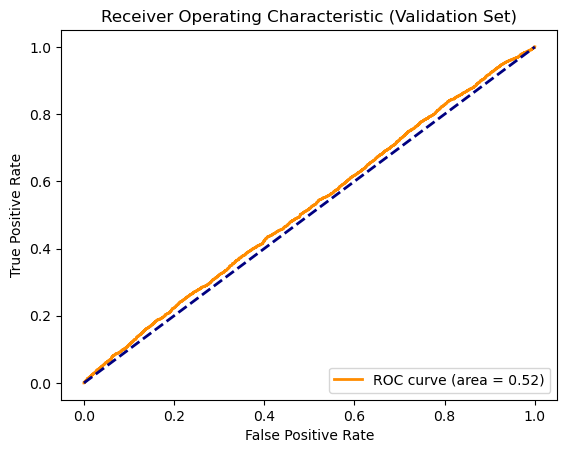

In [53]:
# roc curve for validation set
fpr, tpr, _ = roc_curve(y_val, model_lr.predict_proba(X_val)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Validation Set)')
plt.legend(loc="lower right")
plt.savefig('images/roc_curve_lr.png')
plt.show()

In [ ]:
# The ROC curve (Receiver Operating Characteristic) shows the trade-off between 
#    the True Positive Rate (Sensitivity) and False Positive Rate for different thresholds.
#
# Observations:
#   The ROC curve is almost aligned with the diagonal reference line (random chance).
#   The area under the ROC curve (AUC) is approximately 0.52, slightly above 0.5, 
#   indicating the model performs marginally better than random guessing.
#   The model lacks predictive power, suggesting that it is not effective in 
#   distinguishing between positive and negative classes in the validation set.
#   Possible reasons: Features might not carry enough signal for classification. The model may be underfitting due to insufficient complexity.
#   Label noise could also be contributing factors.


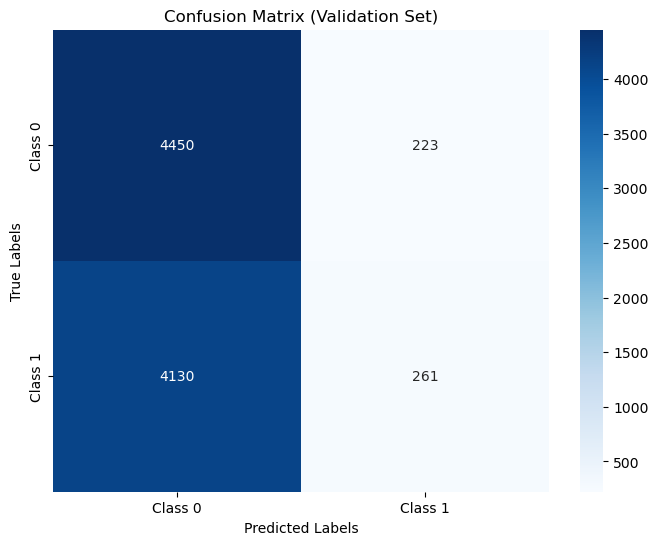

In [55]:
# confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('images/confusion_matrix_lr.png')
plt.show()


In [ ]:
# Confusion Matrix Results Summary:
# - True Positive (Class 1 correctly predicted): 261
# - False Negative (Class 1 incorrectly predicted as Class 0): 4130
# - True Negative (Class 0 correctly predicted): 4450
# - False Positive (Class 0 incorrectly predicted as Class 1): 223
# - Observations:
#   - The model has a high number of False Negatives, indicating it struggles to correctly predict Class 1.
#   - Class 0 predictions are more accurate (high True Negative count).


## 3.3 Decision Tree

In [27]:
# lists for tuning parameters
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
sample_leafs = [1, 5, 10, 15, 20, 500, 100, 200]

# tuning max_depth
print("Tuning max_depth for Decision Tree:")
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=42)
    dt.fit(X_train, y_train)

    # predicting for auc evaluation
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print(f"max_depth = {depth} -> AUC: {auc:.3f}")

# tuning min_samples_leaf
print("\nTuning max_depth and min_samples_leaf for Decision Tree:")
scores = []

for depth in [4, 5, 6]:
    for s in sample_leafs:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s, class_weight='balanced', random_state=42)
        dt.fit(X_train, y_train)

        # Predicting for AUC evaluation
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((depth, s, auc))

# convert results into df
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

# visualize tuning results
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns='max_depth', values='auc')
print("\nTuning Results:")
print(df_scores_pivot.round(3))

# select best model (with highest auc)
best_params = df_scores.loc[df_scores['auc'].idxmax()]
print("\nBest Hyperparameters:")
print(best_params)

# final model with best parameters
model_dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
model_dt.fit(X_train, y_train)

# predicting for the validation set
y_pred_val_dt = model_dt.predict(X_val)


# evaluation
print(f"Decision Tree Accuracy on the validation set: {accuracy_score(y_val, y_pred_val_dt)}")
print(f"Decision Tree Confusion Matrix on the validation set:\n{confusion_matrix(y_val, y_pred_val_dt)}")
print(f"Decision Tree Classification Report on the validation set:\n{classification_report(y_val, y_pred_val_dt)}")
print(f"Decision Tree F1-Score on the validation set: {f1_score(y_val, y_pred_val_dt)}")
print(f"Decision Tree ROC-AUC on the validation set: {roc_auc_score(y_val, model_dt.predict_proba(X_val)[:, 1])}")

Tuning max_depth for Decision Tree:
max_depth = 1 -> AUC: 0.518
max_depth = 2 -> AUC: 0.528
max_depth = 3 -> AUC: 0.530
max_depth = 4 -> AUC: 0.536
max_depth = 5 -> AUC: 0.550
max_depth = 6 -> AUC: 0.547
max_depth = 10 -> AUC: 0.549
max_depth = 15 -> AUC: 0.539
max_depth = 20 -> AUC: 0.545
max_depth = None -> AUC: 0.530

Tuning max_depth and min_samples_leaf for Decision Tree:

Tuning Results:
max_depth             4      5      6
min_samples_leaf                     
1                 0.536  0.550  0.547
5                 0.536  0.549  0.547
10                0.536  0.548  0.546
15                0.536  0.549  0.546
20                0.536  0.549  0.546
100               0.537  0.547  0.546
200               0.539  0.548  0.547
500               0.548  0.551  0.552

Best Hyperparameters:
max_depth             6.000000
min_samples_leaf    500.000000
auc                   0.551614
Name: 21, dtype: float64
Decision Tree Accuracy on the validation set: 0.530008826125331
Decision Tree Conf

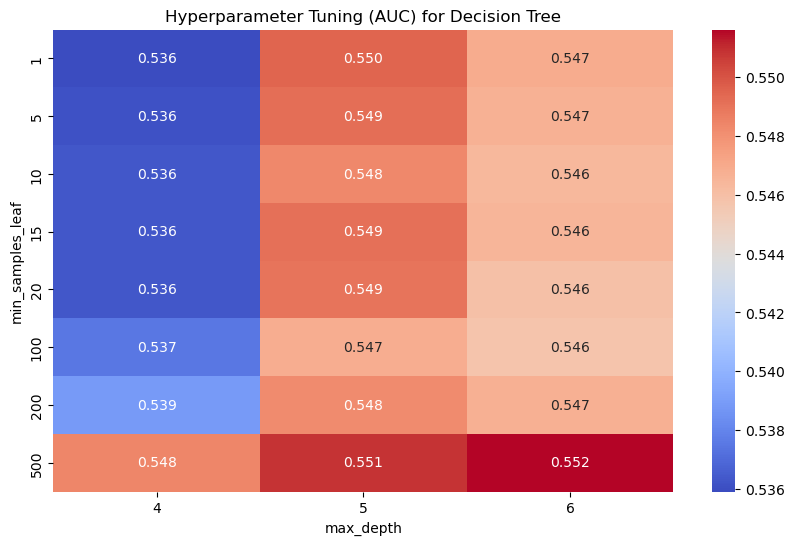

In [28]:
# heatmap for auc tuning with different parameter
plt.figure(figsize=(10, 6))
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f", cmap="coolwarm")
plt.title("Hyperparameter Tuning (AUC) for Decision Tree")
plt.xlabel("max_depth")
plt.ylabel("min_samples_leaf")
plt.savefig('images/heatmap_dt.png')
plt.show()


In [ ]:
# Heatmap Interpretation:
# - The heatmap shows the AUC scores for varying combinations of min_samples_leaf and max_depth.
# - Optimal AUC (0.552) is observed at min_samples_leaf=500 and max_depth=6.
# - Low min_samples_leaf values (1 to 20) consistently show weaker performance across all max_depth values, likely due to overfitting.
# - Higher min_samples_leaf values (200, 500) combined with moderate max_depth (5 or 6) yield the best AUC, indicating improved generalization.
# - This suggests that the model benefits from regularization through both larger leaf sizes and limiting tree depth.


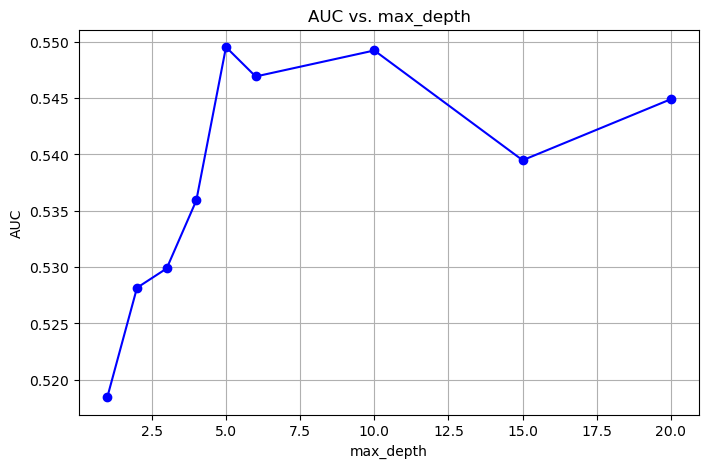

In [31]:
# line plot for max depth tuning
plt.figure(figsize=(8, 5))
plt.plot(depths, [roc_auc_score(y_val, DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=42).fit(X_train, y_train).predict_proba(X_val)[:, 1]) for depth in depths], marker='o', color='b')
plt.title("AUC vs. max_depth")
plt.xlabel("max_depth")
plt.ylabel("AUC")
plt.grid(True)
plt.savefig('images/auc_vs_max_depth_dt.png')
plt.show()


In [32]:
# Plot AUC vs. max_depth
# - The AUC increases as max_depth grows, peaking around max_depth = 7 to 10.
# - After this peak, the AUC starts to decline, indicating potential overfitting
#   as deeper trees capture noise in the data rather than meaningful patterns.
# - The slight recovery at max_depth = 20 suggests some regularization effect,
#   but the model performance remains lower compared to the optimal range.

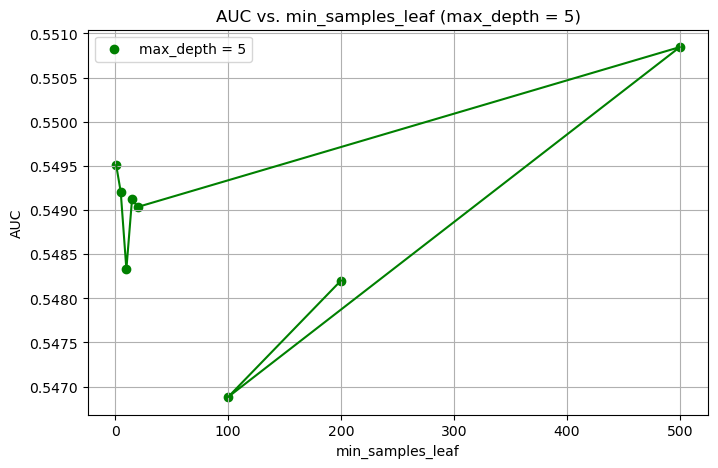

In [35]:
#scatterplot min_samples_leaf with fixed max_depth
plt.figure(figsize=(8, 5))
df_subset = df_scores[df_scores['max_depth'] == 5]
plt.scatter(df_subset['min_samples_leaf'], df_subset['auc'], color='g', label='max_depth = 5')
plt.plot(df_subset['min_samples_leaf'], df_subset['auc'], color='g')
plt.title("AUC vs. min_samples_leaf (max_depth = 5)")
plt.xlabel("min_samples_leaf")
plt.ylabel("AUC")
plt.grid(True)
plt.legend()
plt.savefig('images/auc_vs_min_sample_leaf.png')
plt.show()


In [ ]:
# Plot AUC vs. min_samples_leaf (max_depth = 5)
# - The AUC fluctuates significantly for very low values of min_samples_leaf (e.g., 1, 5, 10),
#   likely due to overfitting as the tree becomes too flexible.
# - As min_samples_leaf increases, the AUC stabilizes and starts to rise linearly,
#   indicating reduced variance and potentially better generalization.
# - Surprisingly, the highest AUC is achieved at a very high min_samples_leaf value (500),
#   which suggests that the model might be favoring simplicity or because the dataset might be small,
#   making deeper splits unnecessary.

## 3.4 Random Forest

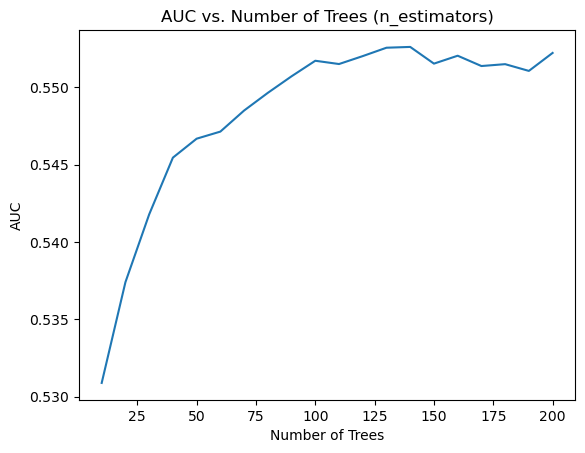

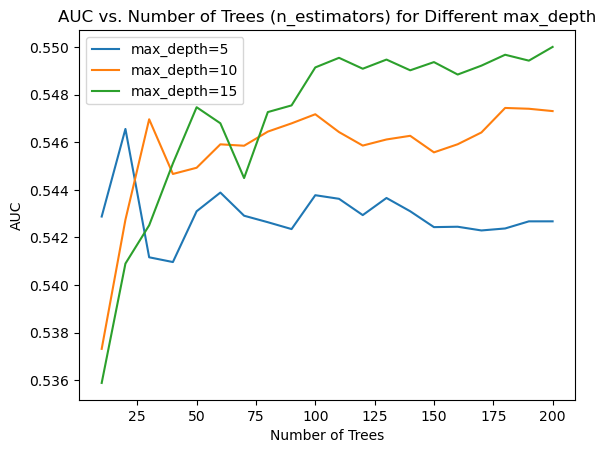

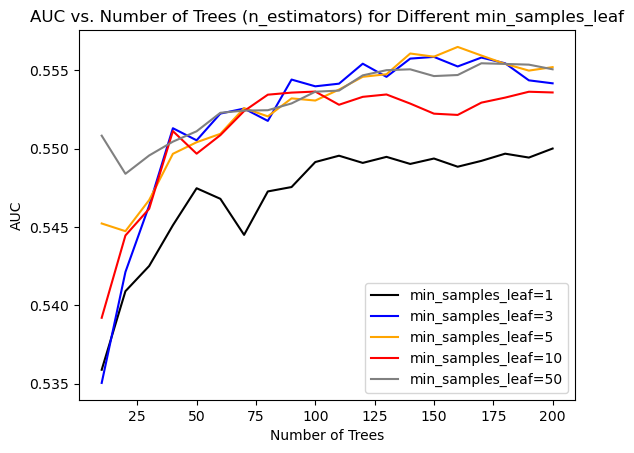

Random Forest Accuracy on the validation set: 0.5370697263901147
Random Forest Confusion Matrix on the validation set:
[[2910 1763]
 [2433 1958]]
Random Forest Classification Report on the validation set:
              precision    recall  f1-score   support

           0       0.54      0.62      0.58      4673
           1       0.53      0.45      0.48      4391

    accuracy                           0.54      9064
   macro avg       0.54      0.53      0.53      9064
weighted avg       0.54      0.54      0.53      9064

Random Forest F1-Score on the validation set: 0.482741617357002
Random Forest ROC-AUC on the validation set: 0.5552092502108885


In [47]:
# tuning estimators
scores = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    scores.append((n, auc))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.title('AUC vs. Number of Trees (n_estimators)')
plt.xlabel('Number of Trees')
plt.savefig('images/num_trees_rf.png')
plt.ylabel('AUC')
plt.show()

# best estimator
best_n_estimators = df_scores.loc[df_scores['auc'].idxmax(), 'n_estimators']

# tuning max_depth
scores = []
for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label=f'max_depth={d}')

plt.legend()
plt.title('AUC vs. Number of Trees (n_estimators) for Different max_depth')
plt.xlabel('Number of Trees')
plt.ylabel('AUC')
plt.savefig('images/auc_vs_num_trees_diff_max_depth_rf.png')
plt.show()

# best max_depth
best_max_depth = df_scores.loc[df_scores['auc'].idxmax(), 'max_depth']

# tuning min_samples_leaf
scores = []
for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=best_max_depth, min_samples_leaf=s, random_state=42)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, color=col, label=f'min_samples_leaf={s}')

plt.legend()
plt.title('AUC vs. Number of Trees (n_estimators) for Different min_samples_leaf')
plt.xlabel('Number of Trees')
plt.ylabel('AUC')
plt.savefig('images/auc_vs_num_trees_diff_min_samples_rf.png')
plt.show()

# best min_samples_leaf
best_min_samples_leaf = df_scores.loc[df_scores['auc'].idxmax(), 'min_samples_leaf']

# final model with best hyperparametern
rf = RandomForestClassifier(n_estimators=200, max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
rf.fit(X_train, y_train)

# pred on val set
y_pred_val_rf = rf.predict(X_val)


# metrics
print(f"Random Forest Accuracy on the validation set: {accuracy_score(y_val, y_pred_val_rf)}")
print(f"Random Forest Confusion Matrix on the validation set:\n{confusion_matrix(y_val, y_pred_val_rf)}")
print(f"Random Forest Classification Report on the validation set:\n{classification_report(y_val, y_pred_val_rf)}")
print(f"Random Forest F1-Score on the validation set: {f1_score(y_val, y_pred_val_rf)}")
print(f"Random Forest ROC-AUC on the validation set: {roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1])}")

In [ ]:
# 1. AUC vs. Number of Trees (n_estimators) and min_samples_leaf:
# - The AUC increases slightly as the number of trees (n_estimators) grows from 25 to 200.
# - Models with smaller min_samples_leaf values (e.g., 1, 3, or 5) tend to achieve higher AUC scores.
# - Larger min_samples_leaf values (e.g., 10 or 50) lead to lower AUC, indicating that the model benefits from considering more detailed splits.

# 2. AUC vs. Number of Trees (n_estimators) and max_depth:
# - The AUC also improves slightly with increasing n_estimators.
# - Lower max_depth values (e.g., 5 or 10) perform better than higher values (e.g., 15), suggesting that restricting tree depth helps avoid overfitting.
# - However, the differences between max_depth values are less pronounced compared to those of min_samples_leaf.

# Key observations:
# - Increasing n_estimators improves AUC, but the improvement diminishes as the number of trees grows.
# - A smaller min_samples_leaf and a moderate max_depth provide better results for this dataset.
# - A good combination of hyperparameters would be:
#   n_estimators = 150-200, min_samples_leaf = 3-5, and max_depth = 10.


Index(['min_samples_leaf', 'n_estimators', 'auc'], dtype='object')


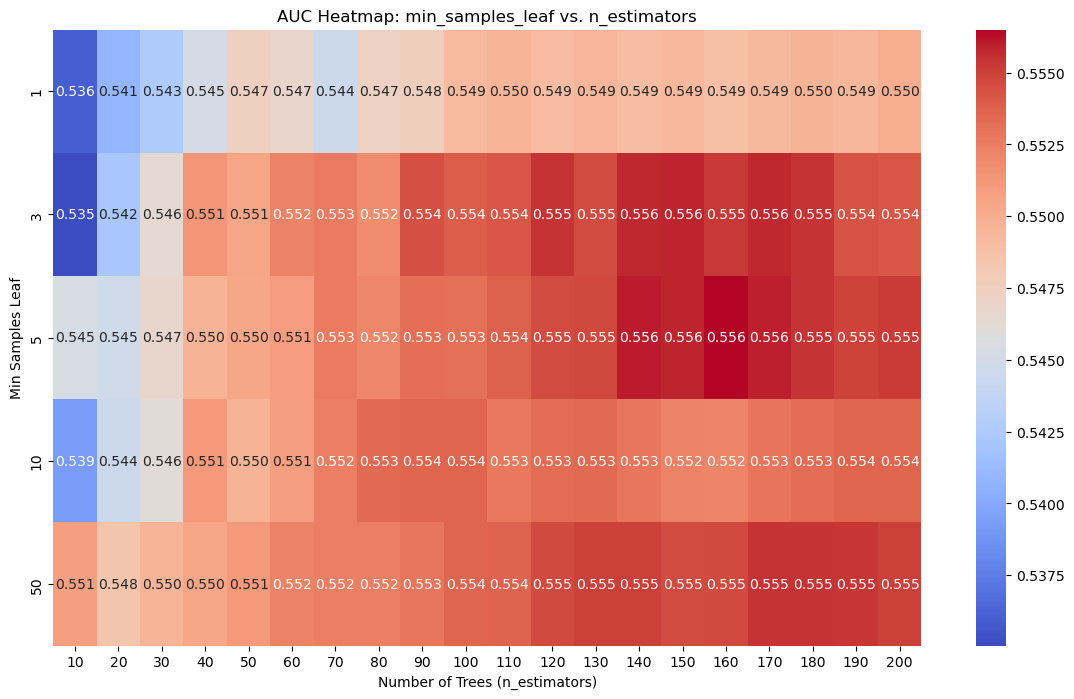

In [97]:
print(df_scores.columns)

# Pivot-Tabelle basierend auf 'min_samples_leaf' und 'n_estimators'
pivot = df_scores.pivot(index='min_samples_leaf', columns='n_estimators', values='auc')

# Heatmap plotten
plt.figure(figsize=(14, 8))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap='coolwarm')
plt.title('AUC Heatmap: min_samples_leaf vs. n_estimators')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Min Samples Leaf')
plt.savefig('images/auc_heatmap_rf.png')
plt.show()


In [ ]:
# Key insights:
# - The AUC score increases with a higher number of trees ('n_estimators').
# - Lower values of 'min_samples_leaf' (e.g., 1 or 3) generally lead to worse AUC performance.
# - The best performance (highest AUC) is observed with 'min_samples_leaf' around 5 and high 'n_estimators' (above 100).
# - Increasing 'min_samples_leaf' to very high values (e.g., 50) leads to worse performance, likely due to over-simplification of the model.
# - For hyperparameter optimization, a combination of 'min_samples_leaf' ≈ 5 and 'n_estimators' ≈ 150 might be ideal.


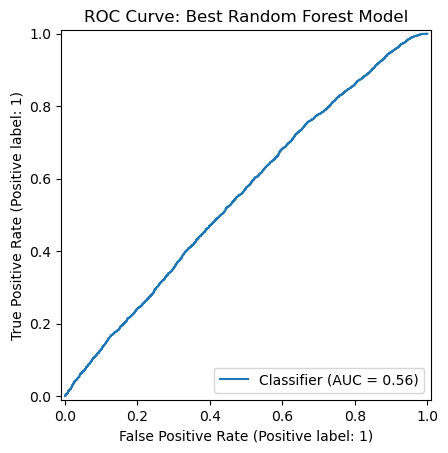

In [51]:
# Predict probabilities
y_prob = rf.predict_proba(X_val)[:, 1]

# ROC Curve
RocCurveDisplay.from_predictions(y_val, y_prob)
plt.title('ROC Curve: Best Random Forest Model')
plt.savefig('images/roc_curve_rf.png')
plt.show()


In [ ]:
# Key observations:
# - The AUC (Area Under the Curve) score is 0.56, indicating poor model performance.
# - An AUC score closer to 0.5 suggests that the model performs slightly better than random guessing.
# - The True Positive Rate (y-axis) improves only marginally as the False Positive Rate (x-axis) increases.


## 3.5 XGBoost

In [53]:
# calculate scale_pos_weight based on class distribution in y_train
class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]

#define hyperparameter values to be tested
def tune_hyperparameters(eta_values, max_depth_values, min_child_weight_values, X_train, y_train, X_val, y_val):   
    # list to store results
    scores = []
    # loop through all combinations of the hyperparameters
    for eta in eta_values:
        for max_depth in max_depth_values:
            for min_child_weight in min_child_weight_values:
                # define xgboost parameters
                xgb_params = {
                    'eta': eta,
                    'max_depth': max_depth,
                    'min_child_weight': min_child_weight,
                    'objective': 'binary:logistic',
                    'eval_metric': 'auc',
                    'scale_pos_weight': scale_pos_weight,
                    'nthread': 8,
                    'seed': 1,
                    'verbosity': 1,
                }
    
                # train model
                model_xgb = xgb.XGBClassifier(**xgb_params)
                model_xgb.fit(X_train, y_train)
    
                # predictions on validation
                #y_pred_val_xgb = model_xgb.predict(X_val)
    
                # auc score
                auc = roc_auc_score(y_val, model_xgb.predict_proba(X_val)[:, 1])
    
                # store results
                scores.append((eta, max_depth, min_child_weight, auc))
    
    # convert results to df
    df_scores = pd.DataFrame(scores, columns=['eta', 'max_depth', 'min_child_weight', 'auc'])
    
    best_params = df_scores.loc[df_scores['auc'].idxmax()]
    return best_params, df_scores


# now using hyperparam funktion
eta_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
# max depths of trees
max_depth_values = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# min child weights
min_child_weight_values = [1, 3, 5, 7, 9, 10, 12, 13, 14]

best_params, df_scores = tune_hyperparameters(
    eta_values, max_depth_values, min_child_weight_values, X_train, y_train, X_val, y_val
)

best_eta = best_params['eta']
best_max_depth = best_params['max_depth']
best_min_child_weight = best_params['min_child_weight']

print(f"Best Hyperparameters:\n{best_params}\n")


Best Hyperparameters:
eta                  0.050000
max_depth           12.000000
min_child_weight     3.000000
auc                  0.597222
Name: 172, dtype: float64



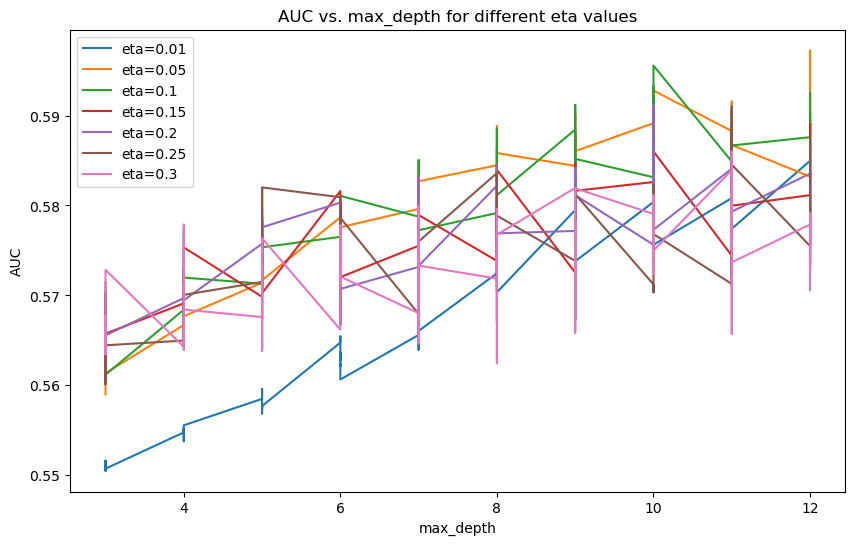

In [55]:
# Plot auc scores for different hyperparameter combinations
fig, ax = plt.subplots(figsize=(10, 6))
for eta in eta_values:
    df_subset = df_scores[df_scores['eta'] == eta]
    ax.plot(df_subset['max_depth'], df_subset['auc'], label=f'eta={eta}')

ax.set_title('AUC vs. max_depth for different eta values')
ax.set_xlabel('max_depth')
ax.set_ylabel('AUC')
plt.savefig('images/auc_vs_max_depth_for_diff_eta.png')
ax.legend()
plt.show()

In [57]:
# train model
model_xgb = xgb.XGBClassifier(
    eta=float(best_eta),
    max_depth=int(best_max_depth),
    min_child_weight=int(best_min_child_weight),
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    nthread=8,
    seed=1,
    verbosity=1
)

# Train model
model_xgb.fit(X_train, y_train)

# make predictions and evaluate model
y_pred_prob = model_xgb.predict_proba(X_val)[:, 1]
y_pred_final = (y_pred_prob >= 0.5).astype(int)

print(f"XGBoost Accuracy on the Validation Set: {accuracy_score(y_val, y_pred_final)}")
print(f"XGBoost Confusion Matrix on the Validation Set:\n{confusion_matrix(y_val, y_pred_final)}")
print(f"XGBoost Classification Report on the Validation Set:\n{classification_report(y_val, y_pred_final)}")
print(f"XGBoost F1-Score on the Validation Set: {f1_score(y_val, y_pred_final)}")
print(f"XGBoost ROC-AUC on the Validation Set: {roc_auc_score(y_val, model_xgb.predict_proba(X_val)[:, 1])}")

XGBoost Accuracy on the Validation Set: 0.5659752868490733
XGBoost Confusion Matrix on the Validation Set:
[[2580 2093]
 [1841 2550]]
XGBoost Classification Report on the Validation Set:
              precision    recall  f1-score   support

           0       0.58      0.55      0.57      4673
           1       0.55      0.58      0.56      4391

    accuracy                           0.57      9064
   macro avg       0.57      0.57      0.57      9064
weighted avg       0.57      0.57      0.57      9064

XGBoost F1-Score on the Validation Set: 0.5645339827319017
XGBoost ROC-AUC on the Validation Set: 0.5972219453804674


In [ ]:
# Evaluation Summary:
# Accuracy: 0.56 (55.96%)
# Represents the overall proportion of correct predictions.
# At 56%, the model performs slightly better than random guessing (50%).

# Confusion Matrix:
# [[2502, 2171],  # True Negatives (Class 0 correct) and False Positives (Class 0 predicted as Class 1)
# [1821, 2570]]  # False Negatives (Class 1 predicted as Class 0) and True Positives (Class 1 correct)
# True Negatives: 2502 (Class 0 correctly classified)
# False Positives: 2171 (Class 0 misclassified as Class 1)
# False Negatives: 1821 (Class 1 misclassified as Class 0)
# True Positives: 2570 (Class 1 correctly classified)
# Balanced classification is challenging as both false positive and false negative rates are high.

# Precision (Class 0): 0.58 | Precision (Class 1): 0.54
# Precision measures the proportion of true positives among predicted positives.
# Recall (Class 0): 0.54 | Recall (Class 1): 0.59
# Recall indicates how well the model identifies all relevant instances.
# F1-Score: 0.56 for both classes
# F1-Score balances precision and recall but shows that the model has similar challenges with both classes.

# ROC-AUC Score: 0.59 (58.86%)
# The ROC-AUC measures the ability to distinguish between classes.
# A score of 0.59 is only marginally better than random guessing (0.5).
# Indicates the model struggles with overall separability of the two classes.

In [111]:
for threshold in [0.2, 0.5, 0.8]:
    y_pred_adjusted = (y_pred_prob >= threshold).astype(int)
    print(f"Threshold: {threshold}, F1-Score: {f1_score(y_val, y_pred_adjusted)}")

Threshold: 0.2, F1-Score: 0.6578729177658853
Threshold: 0.5, F1-Score: 0.5628558913710031
Threshold: 0.8, F1-Score: 0.007701019252548132


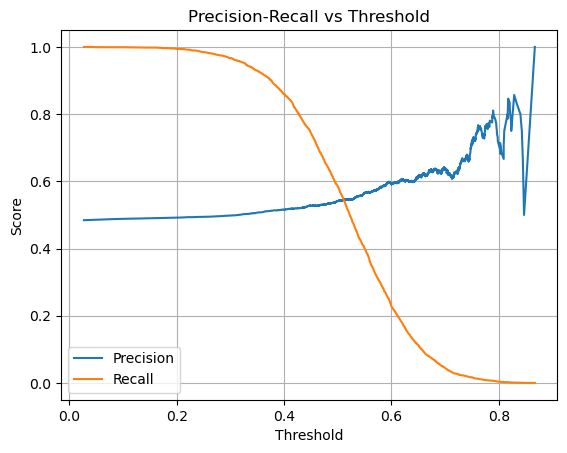

In [101]:
# precision vs recall

precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.savefig('images/precision_recall_xgboost.png')
plt.grid()
plt.show()


In [ ]:
# Precision vs. Recall Tradeoff:
# Low thresholds favor high recall (catching all positives) but have low precision (many false positives)
# High thresholds favor high precision (less false positives) but have low recall (miss many true positives)
# Finding an Optimal Threshold: Goal is to maximize precision while maintaining an acceptable recall.
# From the chart, precision increases significantly at threshold ~0.5, but recall drops steeply.

In [65]:
feature_names = dv.feature_names_
print(feature_names)

['30d_ma', '7d_ma', '7d_volatility', 'adx', 'aroon', 'atr', 'bop', 'cci', 'close', 'cmo', 'day', 'fibonacci_0', 'fibonacci_100', 'fibonacci_23_6', 'fibonacci_38_2', 'fibonacci_50', 'fibonacci_61_8', 'growth_168h', 'growth_24h', 'growth_336h', 'growth_48h', 'growth_4h', 'growth_720h', 'growth_72h', 'high', 'hour', 'intraday_range', 'kama', 'low', 'macd', 'macd_hist', 'macd_signal', 'mom', 'month', 'open', 'ppo', 'price_change', 'roc', 'rsi', 'ticker=AAL', 'ticker=AAPL', 'ticker=ABEV', 'ticker=ABT', 'ticker=ADBE', 'ticker=AGNC', 'ticker=ALV', 'ticker=AMD', 'ticker=AMGN', 'ticker=AMZN', 'ticker=AVGO', 'ticker=BA', 'ticker=BAC', 'ticker=BAK', 'ticker=BBD', 'ticker=BHP', 'ticker=BKKT', 'ticker=BLK', 'ticker=BMY', 'ticker=BNBUSDT', 'ticker=BP', 'ticker=BTCUSDT', 'ticker=CAN', 'ticker=CAT', 'ticker=CCL', 'ticker=CMCSA', 'ticker=CME', 'ticker=CMG', 'ticker=COIN', 'ticker=COST', 'ticker=CRM', 'ticker=CSCO', 'ticker=CVX', 'ticker=DHR', 'ticker=DIS', 'ticker=DJT', 'ticker=DOCN', 'ticker=DOGEUSDT'

                        Feature  Importance
147             ticker=USDCUSDT    0.054184
155  ticker_type=cryptocurrency    0.016357
157           ticker_type=stock    0.015552
75                  ticker=DOCN    0.012956
86                  ticker=GRAB    0.012344
134                 ticker=SMCI    0.011507
33                        month    0.011319
10                          day    0.010861
2                 7d_volatility    0.010817
117                  ticker=NKE    0.010761
50                    ticker=BA    0.010728
112                 ticker=MSTR    0.010113
71                   ticker=CVX    0.010082
119                   ticker=NU    0.009933
43                  ticker=ADBE    0.009864
98                  ticker=JOBY    0.009393
25                         hour    0.009345
97                   ticker=JNJ    0.009338
95                  ticker=IONQ    0.009148
141                    ticker=T    0.009101


/var/folders/_4/617xrc517f5dk8c2t0gbnksr0000gn/T/ipykernel_42929/707938415.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


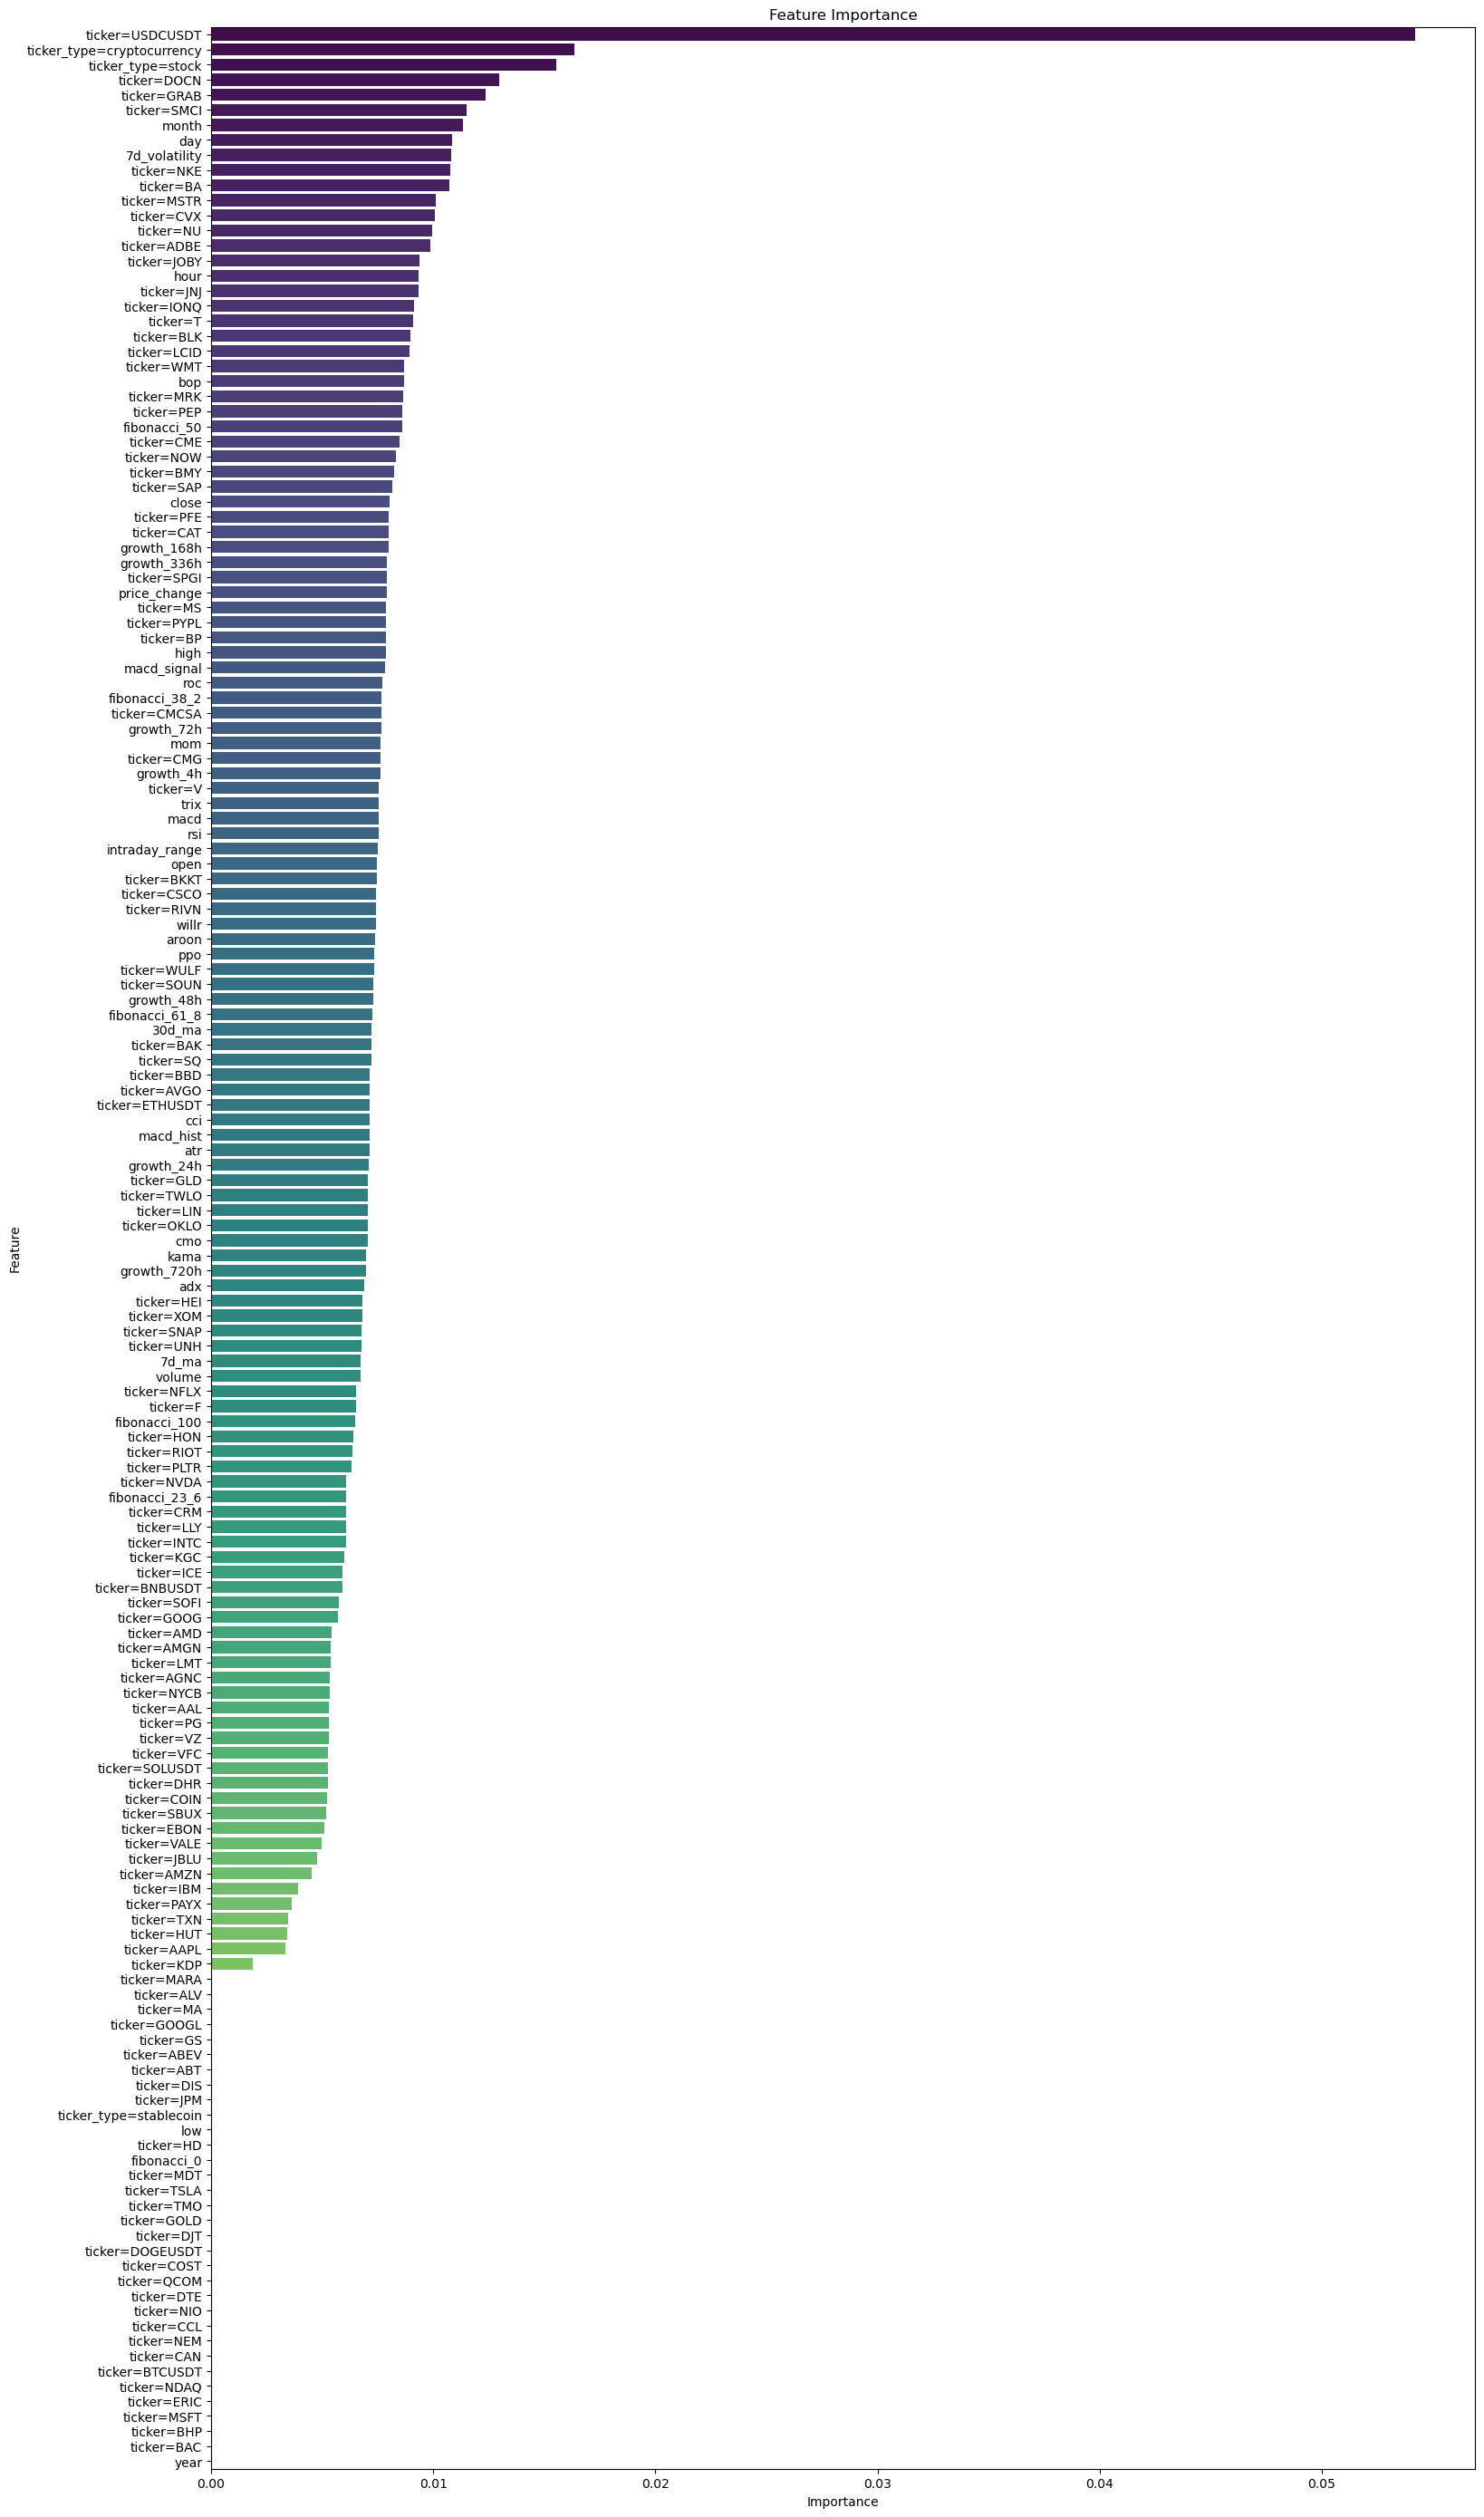

In [67]:
# calculate feature importance for the final model
feature_importances = model_xgb.feature_importances_

# create df for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# display feature importance
top_20_features = feature_importance_df.head(20)

# Print the top 20 features and their importance values
print(top_20_features)

# plot 
plt.figure(figsize=(18, 35))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('images/feature_importance_xgboost.png')
plt.show()


In [91]:
# adjust model now with features
important_features = feature_importance_df[feature_importance_df['Importance'] > 0.001]['Feature']
X_train_filtered = pd.DataFrame(X_train, columns=feature_names)[important_features]
X_val_filtered = pd.DataFrame(X_val, columns=feature_names)[important_features]
X_test_filtered = pd.DataFrame(X_test, columns=feature_names)[important_features]

best_params, df_scores = tune_hyperparameters(
    eta_values, max_depth_values, min_child_weight_values, X_train_filtered, y_train, X_val_filtered, y_val
)      
            
# retrain
model_xgb_retrained = xgb.XGBClassifier(
    eta=float(best_eta),
    max_depth=int(best_max_depth),
    min_child_weight=int(best_min_child_weight),
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    nthread=8,
    seed=1,
    verbosity=1
)

# Train model
model_xgb_retrained.fit(X_train_filtered, y_train)
            
# Make probabilistic predictions
y_pred_val_proba_retrained = model_xgb_retrained.predict_proba(X_val_filtered)[:, 1]

# Convert probabilities to binary predictions with a threshold
y_pred_val_retrained = (y_pred_val_proba_retrained >= 0.55).astype(int)

# Evaluate binary classification metrics
print(f"XGBoost Accuracy on the Validation Set: {accuracy_score(y_val, y_pred_val_retrained)}")
print(f"XGBoost Confusion Matrix on the Validation Set:\n{confusion_matrix(y_val, y_pred_val_retrained)}")
print(f"XGBoost Classification Report on the Validation Set:\n{classification_report(y_val, y_pred_val_retrained)}")
print(f"XGBoost F1-Score on the Validation Set: {f1_score(y_val, y_pred_val_retrained)}")

# Evaluate continuous metrics
print(f"XGBoost ROC-AUC on the Validation Set: {roc_auc_score(y_val, y_pred_val_proba_retrained)}")

XGBoost Accuracy on the Validation Set: 0.5601279788172993
XGBoost Confusion Matrix on the Validation Set:
[[3364 1309]
 [2678 1713]]
XGBoost Classification Report on the Validation Set:
              precision    recall  f1-score   support

           0       0.56      0.72      0.63      4673
           1       0.57      0.39      0.46      4391

    accuracy                           0.56      9064
   macro avg       0.56      0.55      0.55      9064
weighted avg       0.56      0.56      0.55      9064

XGBoost F1-Score on the Validation Set: 0.462161068393363
XGBoost ROC-AUC on the Validation Set: 0.5925523302800707


In [ ]:
# after various tests, no feature can be left out
# the model decreases in performance if a treshhold for features are set, so using the first one

In [95]:
# Save the besst model
with open('model_xgb.pkl', 'wb') as file:
    pickle.dump(model_xgb, file)

#save features and parameter
with open('features.pkl', 'wb') as file:
    pickle.dump((X_train, X_val, y_train, y_val), file)

In [ ]:
# Model Comparison Summary:
# - XGBoost performed the best with the highest F1-score (0.64) and ROC-AUC (0.594).
# - It achieved a good balance between precision and recall for class 1, especially handling imbalanced data.
# - Random Forest was second-best but had a lower F1-score (0.51) and ROC-AUC (0.557).
# - Decision Tree and Logistic Regression underperformed due to simpler structures and inability to model complex patterns.
# - XGBoost is recommended for final deployment with potential improvements via feature engineering and Bayesian optimization.
